In [4]:
import numpy as np # Numpy 
from matplotlib import pyplot as plt # Plotting
import pandas as pd


## Simulate N independent Binary Classifiers and Ensemble them

In [5]:
%matplotlib inline
class SimulateEnsembleClassifier:

    def __init__(self,N=10, prob_lower=0.5, prob_upper=0.6, prob_ground_truth=0.65):
        # N: Number of binary classifiers
        # prob_lower: Lower bound on Probability of classifier
        # prob_upper: Upper bound on Probability of classifier

        self.prob_lower = prob_lower
        self.prob_upper = prob_upper 
        self.prob_ground_truth = prob_ground_truth
        self.N = N
        self.probabilities_classifiers = [0]*self.N # Initialize probability of classification

    def generate_binary_class_probabilities(self):
        # Simulates probability of classifying right for each of the N classifiers

        for n in range(self.N):
            self.probabilities_classifiers[n] = self.prob_lower + np.random.rand()*(self.prob_upper - self.prob_lower)
    
    def generate_ground_truth(self, M):
        # Simulates ground truth labels for binary classification

        self.ground_truth = np.zeros((M))
        for m in range(M):
            random_val = np.random.rand() # Uniform [0,1] random variable
            if random_val <= self.prob_ground_truth:
                self.ground_truth[m] = 1
            else:
                self.ground_truth[m] = 0

    def generate_binary_samples(self, M):
        # Generating Predictions for each of the N classifiers given the ground truth data

        self.binary_samples = np.zeros((M, self.N))

        for sample in range(M):
            for n in range(self.N):
                random_val = np.random.rand()
                if random_val < self.probabilities_classifiers[n]:
                    self.binary_samples[sample,n] = self.ground_truth[sample]
                else:
                    self.binary_samples[sample,n] = 1 - self.ground_truth[sample]
        
                
    def get_ensemble_predictions(self,M,K):

        # Compute Ensemble predictions from first K binary samples
        ensemble_predictions = np.zeros(M)

        for sample in range(M):
            if np.average(self.binary_samples[sample,:K]) > 0.5:
                ensemble_predictions[sample] = 1
            else:
                ensemble_predictions[sample] = 0
        
        return ensemble_predictions
    
    def simulate_ensemble_classifier(self, M):
        
        # 1. Generate Binary Class Probabilities
        self.generate_binary_class_probabilities()

        # 2. Generate Ground Truth
        self.generate_ground_truth(M)

        # 3. Generate Binary Classifier Sample Predictions
        binary_samples = self.generate_binary_samples(M)

        # 4. Generate Ensemble Predictions
        self.ensemble_predictions = self.get_ensemble_predictions(M,N)


    def generate_dataframe(self):

        # 1. Concat all the data
        M = len(self.ground_truth)
        concat_data = np.zeros((M,2 + self.N))
        
        # Set Ground Truth Data
        concat_data[:,0] = self.ground_truth
        concat_data[:,1] = self.ensemble_predictions
        concat_data[:,2:] = self.binary_samples

        # 2. Create a Pandas Data Frame from the concatenated simulated data
        binary_column_names = []
        for n in range(self.N):
            binary_column_names.append('bc_' + str(n))

        df = pd.DataFrame(data = concat_data, columns = ['Ground Truth', 'Ensemble Prediction'] + binary_column_names)

        print(df.shape)

        return df


    # Metrics precision, recall, and f1

    def get_precision_recall_f1(self, truth, prediction):

        precision = sum ([1 if truth[sample] == 1 and  prediction[sample] == 1 else 0 for sample in range(len(truth)) ])/sum(prediction)
        recall = sum ([1 if truth[sample] ==  1 and prediction[sample] == 1 else 0 for sample in range(len(truth)) ])/sum(truth)
        f1 = 2*precision*recall/(precision + recall)

        return precision, recall, f1



    
    def get_simulation_metrics(self):

        avg_binary_classifier_metrics = {}
        ensemble_metrics = {}
        for n in range(self.N):
            avg_binary_classifier_metrics[n] = {'precision': 0, 'recall': 0, 'f1': 0}
            ensemble_metrics[n] =  {'precision': 0, 'recall': 0, 'f1': 0}


        # Get Ensemble Classifier Precision and Recall
        M = len(self.ground_truth)
        for n in range(self.N):
            ensemble_predictions = self.get_ensemble_predictions(M, n+1)
            prec, recall, f1 = self.get_precision_recall_f1(self.ground_truth, ensemble_predictions)
            ensemble_metrics[n]['precision'] = prec
            ensemble_metrics[n]['recall'] = recall 
            ensemble_metrics[n]['f1'] = f1

        # Average Binary Classifier Precision and Recall

        for k in range(self.N):
            avg_precision = 0
            avg_recall = 0
            avg_f1 = 0
            for n in range(k+1):
                prec, recall, f1 = self.get_precision_recall_f1(self.ground_truth, self.binary_samples[:,n])
                avg_precision += prec
                avg_recall += recall
                avg_f1 += f1
            
            avg_binary_classifier_metrics[k]['precision'] = avg_precision/(k+1)
            avg_binary_classifier_metrics[k]['recall'] = avg_recall/(k+1)
            avg_binary_classifier_metrics[k]['f1'] = avg_f1/(k+1)


        return ensemble_metrics, avg_binary_classifier_metrics


    # Plotting

    def plot_precision(self, ensemble_metrics, avg_binary_classifier_metrics):
        plt.plot(range(1,self.N+1), [ensemble_metrics[k]['precision'] for k in range(self.N)], '-xg')
        plt.plot(range(1,self.N+1), [avg_binary_classifier_metrics[k]['precision'] for k in range(self.N)], '-xr')
        plt.xlabel('N')
        plt.ylabel('Precision')
        plt.show()
        

    def plot_recall(self, ensemble_metrics, avg_binary_classifier_metrics):
        plt.plot(range(1,self.N+1), [ensemble_metrics[k]['recall'] for k in range(self.N)], '-xg')
        plt.plot(range(1,self.N+1), [avg_binary_classifier_metrics[k]['recall'] for k in range(self.N)], '-xr')
        plt.xlabel('N')
        plt.ylabel('Recall')
        plt.show()


    def plot_f1(self, ensemble_metrics, avg_binary_classifier_metrics):
        plt.plot(range(1,self.N+1), [ensemble_metrics[k]['f1'] for k in range(self.N)], '-xg')
        plt.plot(range(1,self.N+1), [avg_binary_classifier_metrics[k]['f1'] for k in range(self.N)], '-xr')
        plt.xlabel('N')
        plt.ylabel('f1')
        plt.show()
        
    




## Set Meta-Data for Simulation

In [24]:
N = 200 # Number of binary classifiers to simulate
M = 5000 # Number of examples/data points that are part of the data-set
simulation = SimulateEnsembleClassifier(N) # Instance of the Simulation
simulation.simulate_ensemble_classifier(M)

## Create Data Frame from the simulated Data

In [25]:
df = simulation.generate_dataframe()

(5000, 202)


## Inspect the Data Frame

In [26]:
# Print first p lines in data frame
p = 10
df.head(p)

,Ground Truth,Ensemble Prediction,bc_0,bc_1,bc_2,bc_3,bc_4,bc_5,bc_6,bc_7,...,bc_190,bc_191,bc_192,bc_193,bc_194,bc_195,bc_196,bc_197,bc_198,bc_199
0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
7,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
9,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


## Get Simulation Metrics

In [27]:
ensemble_metrics, binary_classifier_metrics = simulation.get_simulation_metrics()

## Plot Figures

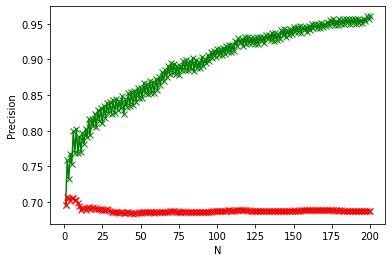

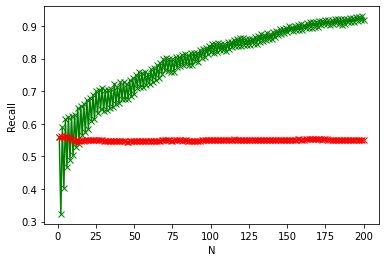

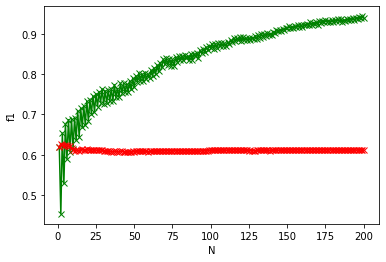

In [28]:
%matplotlib inline

# Precision
simulation.plot_precision(ensemble_metrics, binary_classifier_metrics)

# Recall
simulation.plot_recall(ensemble_metrics, binary_classifier_metrics)

# F1
simulation.plot_f1(ensemble_metrics, binary_classifier_metrics)
